In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random

from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.distributions.empirical_distribution import ECDF

engine = create_engine('sqlite:////home/xiangli/Programming/FundWebsite/fund.db')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def selection(start):
    start_unix = time.mktime((start - relativedelta(years=+1)).timetuple())
    end_unix = time.mktime((start - relativedelta(days=+1)).timetuple())
    data_df = pd.read_sql(sql='select * from price where date between ? and ? order by date asc',
                              con=engine, params=[start_unix, end_unix])

    data_df = data_df.pivot(index='date', columns='fund_id', values='nav')
    data_df = data_df.fillna(method="ffill")
    data_df = data_df.fillna(method="bfill")

    data_df = data_df.pct_change()
    data_df_std = data_df.std()
    data_df = data_df.drop(data_df_std[data_df_std == 0].index.values, axis = 1)
    data_df = data_df.iloc[1:].corr()
    data_df = 1 - data_df * 0.5 - 0.5
    camp = pd.DataFrame(AgglomerativeClustering(n_clusters=4).fit(
        data_df).labels_, index=data_df.index, columns=['label'])
    return camp

In [3]:
profit_clustering = []
t = datetime.strptime("2003-01-01", '%Y-%m-%d')
for i in range(25):
    start = t + relativedelta(years=random.randint(0,13),months=random.randint(0,11),days=random.randint(0,30))
    start_unix = time.mktime(start.timetuple())
    end_unix = time.mktime((start + relativedelta(years=+1)).timetuple())
    camp = selection(start)
    for i in range(40):
        params = []
        for i in range (4):
            params.append((camp[camp["label"] == i].sample(n=1)).index[0])
        params.extend([start_unix,end_unix])
        
        data_df = pd.read_sql(sql='select * from price where fund_id in (?,?,?,?) and date between ? and ? order by date asc',
                                  con=engine, params=params)
        data_df = data_df.pivot(index='date', columns='fund_id', values='nav')
        data_df = data_df.fillna(method="ffill")
        data_df = data_df.fillna(method="bfill")
        
        data_df_interest = pd.read_sql(sql='select * from interest where fund_id in (?,?,?,?) and date between ? and ? order by date asc',
                          con=engine, params=params)
        data_df_interest = data_df_interest.pivot(index='date', columns='fund_id', values='interest')
        
        p = 25000 / data_df.iloc[0] + (data_df_interest / data_df).sum() #持股數
        p = (p * data_df.iloc[-1]).sum() #最後錢
        p = p / 100000 - 1
              
        profit_clustering.append(p)

/home/xiangli/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/home/xiangli/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/home/xiangli/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/home/xiangli/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matri

In [4]:
def selection(start):
    choose = []
    start_unix = time.mktime((start - relativedelta(years=+1)).timetuple())
    end_unix = time.mktime((start - relativedelta(days=+1)).timetuple())
    camp = pd.read_sql(sql='select distinct(fund_id) from price where date between ? and ? order by date asc',
                              con=engine, params=[start_unix, end_unix])
    return camp

In [6]:
profit = []
t = datetime.strptime("2003-01-01", '%Y-%m-%d')
for i in range(25):
    start = t + relativedelta(years=random.randint(0,13),months=random.randint(0,11),days=random.randint(0,30))
    start_unix = time.mktime(start.timetuple())
    end_unix = time.mktime((start + relativedelta(years=+1)).timetuple())
    camp = selection(start)
    for i in range(40):
        params = list(camp.sample(4)["fund_id"].values)
        params.extend([start_unix,end_unix])
        
        data_df = pd.read_sql(sql='select * from price where fund_id in (?,?,?,?) and date between ? and ? order by date asc',
                                  con=engine, params=params)
        data_df = data_df.pivot(index='date', columns='fund_id', values='nav')
        data_df = data_df.fillna(method="ffill")
        data_df = data_df.fillna(method="bfill")
        
        data_df_interest = pd.read_sql(sql='select * from interest where fund_id in (?,?,?,?) and date between ? and ? order by date asc',
                          con=engine, params=params)
        data_df_interest = data_df_interest.pivot(index='date', columns='fund_id', values='interest')
        
        p = 25000 / data_df.iloc[0] + (data_df_interest / data_df).sum() #持股數
        p = (p * data_df.iloc[-1]).sum() #最後錢
        p = p / 100000 - 1
        
#         profit.append((data_df.iloc[-1] / data_df.iloc[0]).mean() - 1)
        profit.append(p)

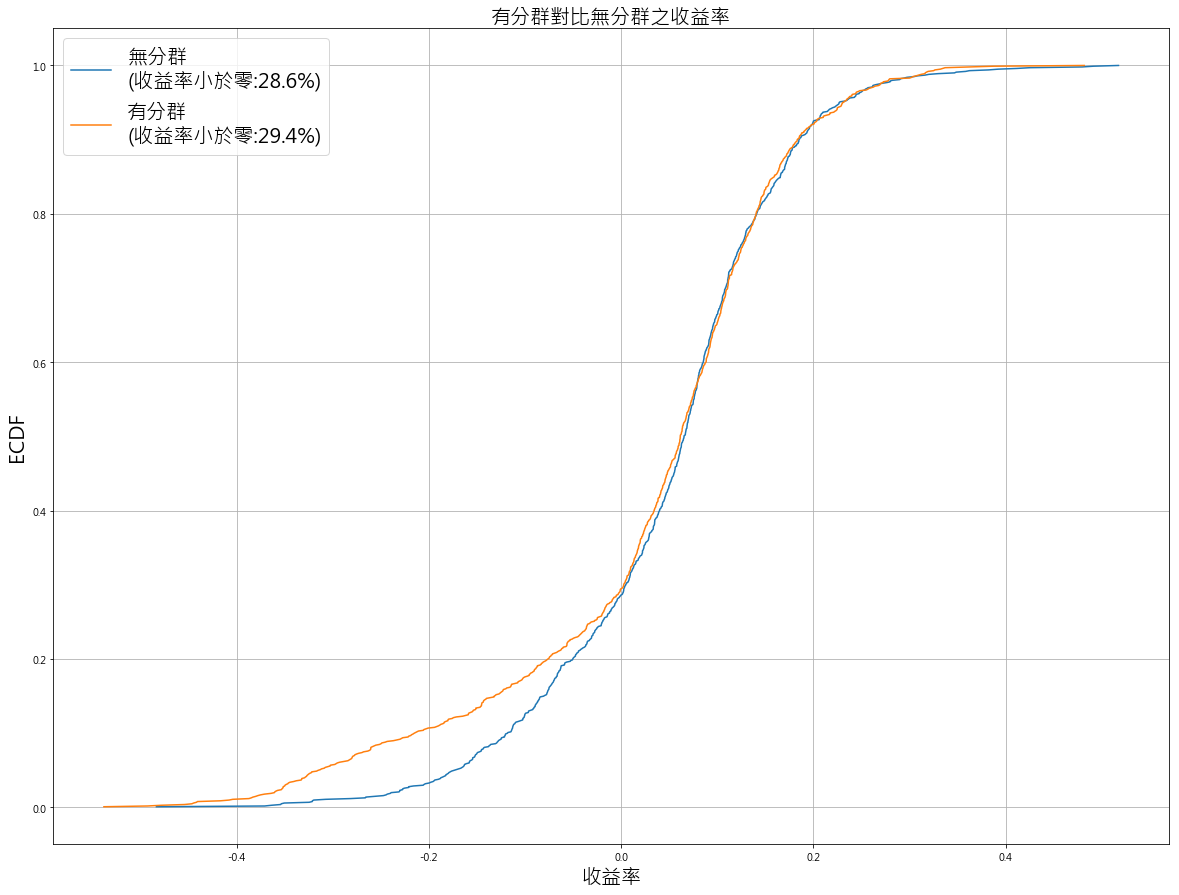

In [7]:
plt.figure(figsize=(20,15))
plt.grid()
plt.title("有分群對比無分群之收益率", fontsize=20)
plt.xlabel("收益率", fontsize=20)
plt.ylabel("ECDF", fontsize=20)
ecdf = ECDF(profit)
lose = str((ecdf.y)[len((ecdf.x)[ecdf.x < 0]) - 1] * 100)
plt.plot(ecdf.x, ecdf.y, label="無分群\n(收益率小於零:"+lose+"%)", linewidth=1.5)
ecdf = ECDF(profit_clustering)
lose = str((ecdf.y)[len((ecdf.x)[ecdf.x < 0]) - 1] * 100)
plt.plot(ecdf.x,ecdf.y, label="有分群\n(收益率小於零:"+lose+"%)", linewidth=1.5)
plt.legend(loc='upper left', fontsize=20)
# plt.savefig("clustering.png")
plt.show()

In [2]:
import math
from business_calendar import Calendar

In [3]:
a = datetime.strptime("2016-01", '%Y-%m')
b = datetime.strptime("2018-12", '%Y-%m')
days = Calendar().busdaycount(a, b)
years = (b - a).days / 365.25
Δt = years / days
mean_profit = 0.16
std_profit = 0.05
price = pd.DataFrame({'price':120}, index=[i for i in range((b - a).days)])

In [4]:
for i in range((b - a).days - 1):
    price.iloc[i+1] = price.iloc[i] * (1 + mean_profit * Δt + np.random.randn() * std_profit* math.sqrt(Δt))

In [5]:
(((price / price.iloc[0]) - 1) * 100).iloc[-1].values[0]

239.98137953937598

In [6]:
price

,price
0,120.000000
1,119.732836
2,119.943160
3,119.770968
4,119.594922
5,119.575716
6,119.390895
7,119.070849
8,119.492618
9,119.338890
